In [ ]:
import random
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
import re
import copy

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
seed_number = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(seed_number) # Seed 고정

In [ ]:
drive_path = "/content/drive/MyDrive/데이터 경진대회/제주 특산물 가격 예측"
train_data_path = drive_path + "/train.csv"
test_data_path = drive_path + "/test.csv"
sample_submission_path = drive_path + "/sample_submission.csv"

In [ ]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [ ]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

In [ ]:
category_list = train_df["ID"].str.replace(r'_\d{8}$', '', regex=True).unique()

In [ ]:
def handle_data_to_prophet(df) :
  transformed_df = df[["ID", "timestamp", "price(원/kg)"]]
  transformed_df["ID"] = transformed_df["ID"].str.replace(r'_\d{8}$', '', regex=True)
  transformed_df = transformed_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})
  return transformed_df.copy()

In [ ]:
prophet_train_data = handle_data_to_prophet(train_df)

In [ ]:
prophet_train_data.head(5)

,ID,ds,y
0,TG_A_J,2019-01-01,0.0
1,TG_A_J,2019-01-02,0.0
2,TG_A_J,2019-01-03,1728.0
3,TG_A_J,2019-01-04,1408.0
4,TG_A_J,2019-01-05,1250.0


### 해당 날짜의 가격이 0인지 0이 아닌지를 판단하는 모델 설계

In [ ]:
class BinaryLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, device):
    super(BinaryLSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    out = self.sigmoid(out)
    return out

In [ ]:
def label_encoding_category_columns_and_get_label_encoder(train_df, test_df, category_columns):
  le_dict = {}
  for column in category_columns:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    test_df[column] = le.transform(test_df[column])
  return le_dict

In [ ]:
batch_size = 256
seq_len = 356

In [ ]:
qual_col = ['item', 'corporation', 'location']

le_dict = label_encoding_category_columns_and_get_label_encoder(train_df, test_df, qual_col)

In [ ]:
train_df.head(5)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,4,0,0,0.0,0.0
1,TG_A_J_20190102,2019-01-02,4,0,0,0.0,0.0
2,TG_A_J_20190103,2019-01-03,4,0,0,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,4,0,0,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,4,0,0,32352.0,1250.0


In [ ]:
def handle_data_to_binary_lstm(df) :
  transformed_df = df[["ID", "timestamp", "item", "corporation", "location", "price(원/kg)"]]
  transformed_df["timestamp"] = pd.to_datetime(df["timestamp"])
  transformed_df["ID"] = transformed_df["ID"].str.replace(r'_\d{8}$', '', regex=True)
  transformed_df["day of week"] = transformed_df["timestamp"].dt.dayofweek
  transformed_df["month"] = transformed_df["timestamp"].dt.month
  transformed_df["day of month"] = transformed_df["timestamp"].dt.day
  transformed_df = transformed_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})
  transformed_df.loc[transformed_df["y"] > 0, "y"] = 1
  return transformed_df.drop(columns=["ds"])

In [ ]:
def separate_data_label(df, label_key, except_keys) :
  data = df.drop(columns=[label_key, *except_keys])
  label = df[label_key]
  return data, label

In [ ]:
class BinaryLstmDataset(Dataset):
  def __init__(self, dataframe):
    self.data = dataframe[['day of week', 'month', 'day of month']].values
    self.labels = dataframe['y'].values

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = {'input': torch.tensor(self.data[idx], dtype=torch.float32),
              'label': torch.tensor(self.labels[idx], dtype=torch.float32)}
    return sample

In [ ]:
def build_lstm_dataset(df, seq, key_position) :
  x = []
  y = []

  for i in range(0, len(df) - seq):
    _x = df[i:i+seq, 1:]
    _y = df[i+seq, key_position]
    x.append(_x.astype(np.float32))
    y.append(_y)
  return np.array(x), np.array(y)

In [ ]:
train_lstm_data = handle_data_to_binary_lstm(train_df)

In [ ]:
test_df_with_empty_price = test_df.copy()
test_df_with_empty_price["price(원/kg)"] = 0
test_lstm_data = handle_data_to_binary_lstm(test_df_with_empty_price)

In [ ]:
test_lstm_data.head(5)

,ID,item,corporation,location,y,day of week,month,day of month
0,TG_A_J,4,0,0,0,5,3,4
1,TG_A_J,4,0,0,0,6,3,5
2,TG_A_J,4,0,0,0,0,3,6
3,TG_A_J,4,0,0,0,1,3,7
4,TG_A_J,4,0,0,0,2,3,8


In [ ]:
total_x, total_y = np.empty((0, seq_len, 7)), np.array([])
for category in category_list:
  current_category_data = train_lstm_data[train_lstm_data["ID"] == category]
  _x, _y = build_lstm_dataset(np.array(current_category_data), seq_len, 4)

  total_x = np.concatenate((total_x, _x), axis = 0)
  total_y = np.concatenate((total_y, _y), axis = 0)

In [ ]:
_train_x_tensor = torch.FloatTensor(total_x).to(device)
_train_y_tensor = torch.FloatTensor(total_y).to(device)
lstm_dataset = TensorDataset(_train_x_tensor, _train_y_tensor)
lstm_dataloader = DataLoader(lstm_dataset, batch_size, shuffle=True)

In [ ]:
train_dataloader, val_dataloader = random_split(lstm_dataset, [0.8, 0.2])

In [ ]:
train_dataloader = DataLoader(train_dataloader, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataloader, batch_size=batch_size, shuffle=False)

In [ ]:
binary_lstm_model = BinaryLSTM(7, seq_len, 1, 2, device).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(binary_lstm_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
iter = 100

In [ ]:
len(train_dataloader)

143

In [ ]:
binary_lstm_model.load_state_dict(torch.load(drive_path + f"/binary_lstm_weight.pt", map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
for epoch in range(iter) :
  binary_lstm_model.train()

  for i, batch in enumerate(train_dataloader):
    inputs = batch[0]#.to(device)
    labels = batch[1].long()#.to(device)
    outputs = binary_lstm_model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 20 == 19 :
      print(f"Epoch {epoch + 1} / {iter} - {i}, train loss : {loss:.4f}")

  scheduler.step()
  binary_lstm_model.eval()
  with torch.no_grad():
    val_loss = 0

    for inputs, labels in val_dataloader:
      outputs = binary_lstm_model(inputs)
      val_loss += criterion(outputs, labels.long())

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1} / {iter}, valiodation loss : {avg_val_loss:.4f}")

    if avg_val_loss < min_val_loss :
      print(f"model weight saved! valiodation loss : {min_val_loss:.4f} -> {avg_val_loss:.4f}")
      min_val_loss = avg_val_loss
      weight_path = drive_path + f"/binary_lstm_weight.pt"
      torch.save(binary_lstm_model.state_dict(), weight_path)

In [ ]:
binary_lstm_model.eval()
bce = nn.BCELoss()
for inputs, labels in val_dataloader:
  outputs = binary_lstm_model(inputs)
  print(f"{outputs[20:25]}")
  print(f"{labels[20:25]}")
  # BCE 적용해볼것!
  print(f"{criterion(outputs, labels.long())}")
  break

tensor([[2.6386e-05, 9.9997e-01],
        [1.1064e-05, 9.9999e-01],
        [1.0773e-04, 9.9990e-01],
        [3.4323e-07, 1.0000e+00],
        [1.0000e+00, 4.4714e-08]], grad_fn=<SliceBackward0>)
tensor([1., 1., 1., 1., 0.])
0.3692847192287445


In [ ]:
train_lstm_data.tail(5)

,ID,item,corporation,location,y,day of week,month,day of month
59392,RD_F_J,3,5,0,1.0,0,2,27
59393,RD_F_J,3,5,0,1.0,1,2,28
59394,RD_F_J,3,5,0,1.0,2,3,1
59395,RD_F_J,3,5,0,1.0,3,3,2
59396,RD_F_J,3,5,0,1.0,4,3,3


In [ ]:
len(test_lstm_data[test_lstm_data["ID"] == "RD_F_J"])

28

In [ ]:
non_zero_dict = {}
for category in category_list :
  current_category_data = train_lstm_data[train_lstm_data["ID"] == category].iloc[-seq_len:]
  current_category_data = current_category_data.drop(columns=["ID"])

  current_category_predict_data = test_lstm_data[test_lstm_data["ID"] == category]
  current_category_predict_data = current_category_predict_data.drop(columns=["ID"])

  predict_steps = len(current_category_predict_data)

  predict_list = []
  for i in range(predict_steps) :
    current_input = pd.concat([current_category_data[i:], current_category_predict_data[:i]], axis=0)
    input_tensor = torch.tensor(current_input.values, dtype=torch.float32)
    input_tensor = input_tensor[None, :]

    with torch.no_grad():
      binary_lstm_model.eval()
      output = binary_lstm_model(input_tensor).tolist()[0]
      predict = output.index(max(output))

    current_category_predict_data.loc[current_category_predict_data.index[i], "y"] = predict
    predict_list.append(predict)

  non_zero_dict[category] = predict_list
  print(f"{category} non-zero predict is done!")

TG_A_J non-zero predict is done!
TG_A_S non-zero predict is done!
TG_B_J non-zero predict is done!
TG_B_S non-zero predict is done!
TG_C_J non-zero predict is done!
TG_C_S non-zero predict is done!
TG_D_J non-zero predict is done!
TG_D_S non-zero predict is done!
TG_E_J non-zero predict is done!
TG_E_S non-zero predict is done!
CR_A_J non-zero predict is done!
CR_B_J non-zero predict is done!
CR_C_J non-zero predict is done!
CR_D_J non-zero predict is done!
CR_D_S non-zero predict is done!
CR_E_J non-zero predict is done!
CR_E_S non-zero predict is done!
CB_A_J non-zero predict is done!
CB_A_S non-zero predict is done!
CB_D_J non-zero predict is done!
CB_E_J non-zero predict is done!
RD_A_J non-zero predict is done!
RD_A_S non-zero predict is done!
RD_C_S non-zero predict is done!
RD_D_J non-zero predict is done!
RD_D_S non-zero predict is done!
RD_E_J non-zero predict is done!
RD_E_S non-zero predict is done!
BC_A_J non-zero predict is done!
BC_A_S non-zero predict is done!
BC_B_J non

In [ ]:
original_non_zero_dict = non_zero_dict.copy()

In [ ]:
def get_average_of_list(lst):
    return sum(lst) / len(lst)

In [ ]:
for category in category_list :
  current_non_zero_list = non_zero_dict[category]
  print(f"{category} : {round(get_average_of_list(current_non_zero_list), 2)}")

TG_A_J : 0.86
TG_A_S : 0.86
TG_B_J : 0.86
TG_B_S : 0.86
TG_C_J : 0.86
TG_C_S : 0.86
TG_D_J : 0.82
TG_D_S : 0.86
TG_E_J : 0.86
TG_E_S : 0.86
CR_A_J : 0.86
CR_B_J : 0.0
CR_C_J : 0.75
CR_D_J : 0.86
CR_D_S : 0.0
CR_E_J : 0.86
CR_E_S : 0.0
CB_A_J : 0.71
CB_A_S : 0.89
CB_D_J : 0.86
CB_E_J : 0.0
RD_A_J : 0.86
RD_A_S : 0.86
RD_C_S : 0.0
RD_D_J : 0.0
RD_D_S : 0.86
RD_E_J : 0.86
RD_E_S : 0.0
BC_A_J : 0.86
BC_A_S : 0.86
BC_B_J : 0.86
BC_B_S : 0.0
BC_C_J : 0.86
BC_C_S : 0.0
BC_D_J : 0.86
BC_E_J : 0.86
BC_E_S : 0.86
CB_F_J : 0.86
RD_F_J : 0.86


### Prophet 하이퍼 파라미터 탐색 전, 데이터 전처리
- 가격이 0이 아닌 데이터 사이에 너무 큰 공백을 막기 위해, 0이 아닌 데이터간의 간격이 60일을 넘어간 경우 중간 날짜에 y=0인 임시 데이터를 insert

In [ ]:
search_data = prophet_train_data[prophet_train_data["ID"] == "CR_E_S"].drop(columns=["ID"]).sort_values("ds").copy()

In [ ]:
train_size = int(len(search_data) * 0.8)
origin_train_data = search_data[:train_size]
# 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
origin_train_data = origin_train_data[origin_train_data["y"] > 0]
origin_test_data = search_data[train_size:]

In [ ]:
from datetime import datetime, timedelta
def insert_rows(df):
    result_df = pd.DataFrame(columns=df.columns)

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        result_df = result_df.append(current_row, ignore_index=True)

        date_diff = (next_row['ds'] - current_row['ds']).days

        if date_diff > 60:
            for j in range(1, date_diff):
                new_date = current_row['ds'] + timedelta(days=j)
                new_row = {'y' : 0, 'ds' : new_date}
                result_df = result_df.append(new_row, ignore_index=True)

    result_df = result_df.append(df.iloc[-1], ignore_index=True)

    return result_df

In [ ]:
test_data = search_data[:train_size]
test_data = test_data[test_data["y"] > 0]
test_data = insert_rows(test_data)

In [ ]:
test_data.head()

,ds,y
0,2019-01-11,1092.0
1,2019-02-02,1238.0
2,2019-02-13,1006.0
3,2019-02-14,0.0
4,2019-02-15,0.0


In [ ]:
import matplotlib.pyplot as plt

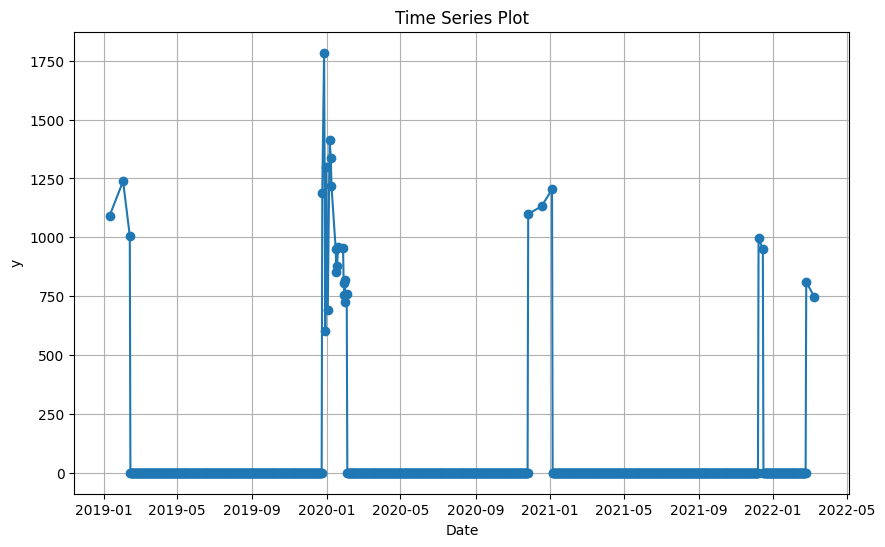

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], marker='o', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)
plt.show()

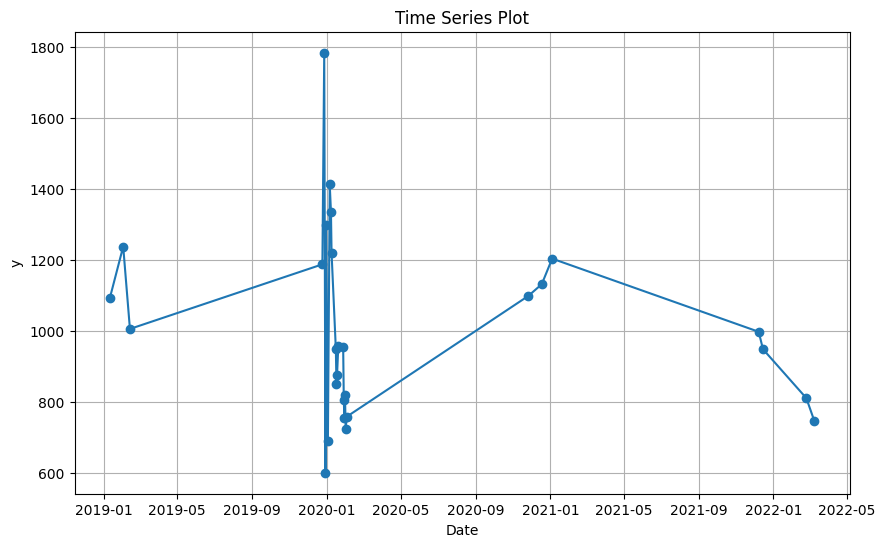

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(origin_train_data['ds'], origin_train_data['y'], marker='o', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)
plt.show()

### Prophet 하이퍼 파라미터 탐색

In [ ]:
param_grid = {
    'growth': ['linear'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 5, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'holidays_prior_scale': [0.1, 1, 5],
}

In [ ]:
def prophet_grid_search(num_iterations, param_grid, train_data, y):
  results = []

  for _ in range(num_iterations) :
    random_params = {
        key : random.choice(value) for key, value in param_grid.items()
    }

    current_model = Prophet(**random_params)
    current_model.fit(train_data)

    y_size = len(y)

    future = current_model.make_future_dataframe(periods=y_size)
    forecast = current_model.predict(future)
    m_predict = forecast["yhat"].values[-y_size:]

    se = np.square(m_predict - y)
    rmse = np.sqrt(np.mean(se))

    results.append((random_params, rmse))
  return results


In [ ]:
model_per_category = {}
for category in category_list:
  search_data = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds").copy()
  train_size = int(len(search_data) * 0.8)
  search_train_data = search_data[:train_size]
  # 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
  search_train_data = search_train_data[search_train_data["y"] > 0]
  search_train_data = insert_rows(search_train_data)
  search_test_data = search_data[train_size:]
  y = search_test_data["y"].values[:]
  results = prophet_grid_search(30, param_grid, search_train_data, y)
  sorted_results = sorted(results, key=lambda x : x[1])[:5]
  model_per_category[category] = sorted_results

In [ ]:
import json
file_path = drive_path + '/prophet_4.txt'
def save_prophet_params(dictionary, file_path):
  with open(file_path, 'w') as file :
    json.dump(dictionary, file)

def extract_prophet_params(file_path):
  with open(file_path, 'r') as file :
    loaded_dict = json.load(file)
  return loaded_dict

In [ ]:
save_prophet_params(model_per_category, file_path)

In [ ]:
saved_result = extract_prophet_params(file_path)
model_per_category = saved_result

In [ ]:
test_result = model_per_category["CR_E_S"]

In [ ]:
best_params, best_rmse = min(test_result, key=lambda x: x[1])

In [ ]:
best_params

{'growth': 'linear',
 'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 10,
 'changepoint_range': 0.8,
 'yearly_seasonality': False,
 'weekly_seasonality': False,
 'daily_seasonality': True,
 'holidays_prior_scale': 5}

In [ ]:
train_size = int(len(search_data) * 0.8)
search_train_data = search_data[:train_size]
search_train_data = search_train_data[search_train_data["y"] > 0]
search_train_data = insert_rows(search_train_data)
search_test_data = search_data[train_size:]

In [ ]:
search_train_data

,ds,y
0,2019-01-11,1092.0
1,2019-02-02,1238.0
2,2019-02-13,1006.0
3,2019-02-14,0.0
4,2019-02-15,0.0
...,...,...
1040,2022-02-21,0.0
1041,2022-02-22,0.0
1042,2022-02-23,0.0
1043,2022-02-24,811.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpllpuv0ph/wor9e0bl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllpuv0ph/hhn8pbp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84523', 'data', 'file=/tmp/tmpllpuv0ph/wor9e0bl.json', 'init=/tmp/tmpllpuv0ph/hhn8pbp8.json', 'output', 'file=/tmp/tmpllpuv0ph/prophet_model_r8r215k/prophet_model-20231115141249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


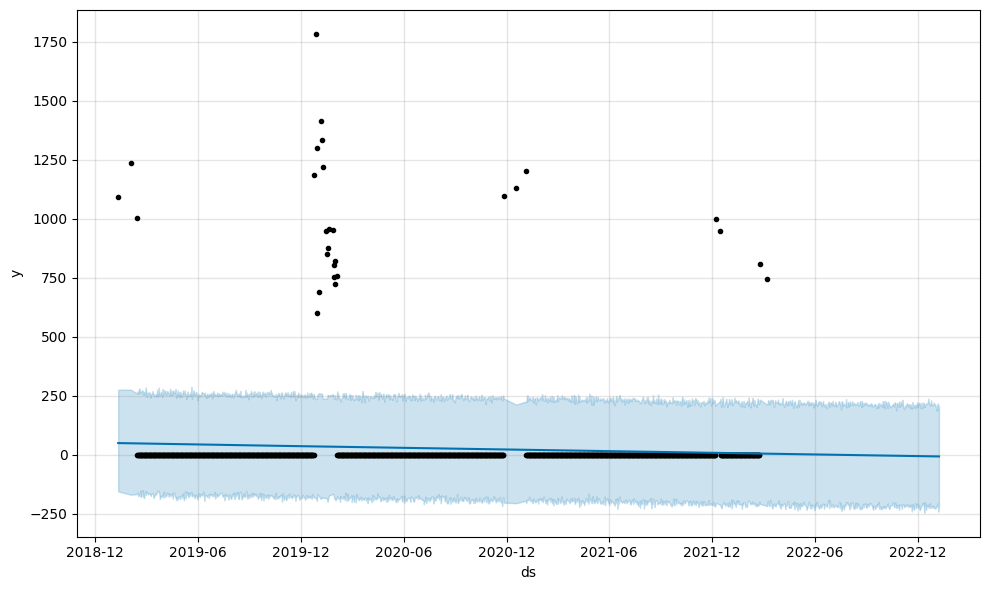

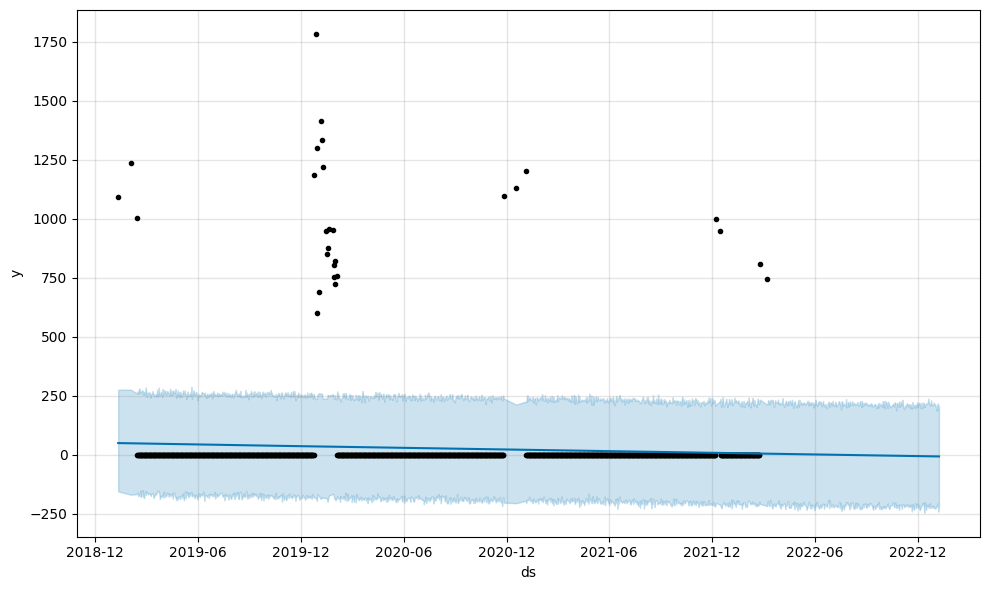

In [ ]:
test_model = Prophet(**best_params)
test_model.fit(search_train_data)
future = test_model.make_future_dataframe(periods=305)
forecast = test_model.predict(future)
test_model.plot(forecast)

In [ ]:
prophet_map = {}

In [ ]:
for category in category_list :
  category_prophet_result = model_per_category[category]
  best_params, best_rmse = min(category_prophet_result, key=lambda x: x[1])
  main_model = Prophet(
      **best_params
  )
  current_category_train_x = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds")
  current_category_train_x = current_category_train_x[current_category_train_x["y"] > 0]
  current_category_train_x = insert_rows(current_category_train_x)

  prophet_map[category] = main_model.fit(current_category_train_x)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpllpuv0ph/jdx6r0ue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllpuv0ph/wj8b0_gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14127', 'data', 'file=/tmp/tmpllpuv0ph/jdx6r0ue.json', 'init=/tmp/tmpllpuv0ph/wj8b0_gk.json', 'output', 'file=/tmp/tmpllpuv0ph/prophet_modelc8sl7kqm/prophet_model-20231115140452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:04:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllpuv0ph/9un_25wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpllpuv0ph/vy91kj0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
test_df["price(원/kg)"] = 0

In [ ]:
prophet_test_data = handle_data_to_prophet(test_df)

In [ ]:
result_map = {}
for category in category_list :
  current_category_test_x = prophet_test_data[prophet_test_data["ID"] == category].drop(columns=["ID"])
  model = prophet_map[category]
  y = model.predict(current_category_test_x)
  result_map[category] = y["yhat"].values.tolist()

In [ ]:
copy_result_map = copy.deepcopy(result_map)

In [ ]:
def assign_result(row) :
  category = re.sub(r'_\d{8}$', '', row["ID"])
  result = copy_result_map[category]
  non_zero = non_zero_dict[category]
  return result.pop(0) * non_zero.pop(0)

In [ ]:
submission = pd.read_csv(sample_submission_path)

In [ ]:
submission.head()

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0


In [ ]:
submission["answer"] = 0

In [ ]:
submission["answer"] = submission.apply(assign_result, axis=1)

In [ ]:
submission.tail(50)

,ID,answer
1042,CB_F_J_20230310,648.676641
1043,CB_F_J_20230311,642.101270
1044,CB_F_J_20230312,0.000000
1045,CB_F_J_20230313,679.607878
1046,CB_F_J_20230314,674.543854
1047,CB_F_J_20230315,666.665151
1048,CB_F_J_20230316,661.977170
1049,CB_F_J_20230317,665.729540
1050,CB_F_J_20230318,658.653094
1051,CB_F_J_20230319,0.000000


In [ ]:
submission.loc[submission["answer"] < 0, "answer"] = 0

In [ ]:
submission[submission["answer"] < 0]

,ID,answer


In [ ]:
submission.to_csv(drive_path + "/submission_231115_1.csv", index=False)

In [ ]:
len(category_list)

39